<a href="https://colab.research.google.com/github/UmairRuman/CNN_classfication_workshops/blob/main/Notebooks/%3CCaltech_Dataset%3E%3CVGG%3E%3CUmair%20Ruman%3E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Important Libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB3, EfficientNetB6, EfficientNetB7,
    ResNet50, ResNet101, ResNet152V2,
    DenseNet121, DenseNet169, DenseNet201,
    VGG16, VGG19,
    InceptionV3, InceptionResNetV2,
    MobileNetV2, MobileNetV3Large
)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# **Dataset Configuration class**

In [ ]:
class Caltech101Config:
    """Configuration class for Caltech-101 training pipeline"""

    def __init__(self):
        # Dataset parameters
        self.dataset_name = 'caltech101'
        self.num_classes = 102
        self.img_size = 128
        self.batch_size = 16
        self.validation_split = 0.2

        # Training parameters
        self.epochs = 50
        self.initial_learning_rate =  0.001
        self.min_learning_rate = 1e-7
        self.patience = 5
        self.early_stopping_patience = 10

        # Model parameters
        self.dropout_rate = 0.3
        self.l2_regularization = 1e-4
        self.fine_tune_at = -4

        # Augmentation parameters
        self.rotation_range = 20
        self.zoom_range = 0.15
        self.width_shift_range = 0.1
        self.height_shift_range = 0.1
        self.horizontal_flip = True

        # Output directories
        self.model_dir = Path('models')
        self.log_dir = Path('logs')
        self.results_dir = Path('results')

        # Create directories
        for dir_path in [self.model_dir, self.log_dir, self.results_dir]:
            dir_path.mkdir(exist_ok=True)

# **Every architecture Preprocessor**

In [ ]:
class Caltech101DataProcessor:

    def __init__(self, config):
        self.config = config
        self.preprocessing_functions = {
            'efficientnet': tf.keras.applications.efficientnet.preprocess_input,
            'resnet': tf.keras.applications.resnet.preprocess_input,
            'densenet': tf.keras.applications.densenet.preprocess_input,
            'vgg': tf.keras.applications.vgg16.preprocess_input,
            'inception': tf.keras.applications.inception_v3.preprocess_input,
            'mobilenet': tf.keras.applications.mobilenet_v2.preprocess_input,
        }

    def load_dataset(self):
        """Load and split Caltech-101 dataset"""
        print("Loading Caltech-101 dataset...")

        # Load dataset with info
        (ds_train, ds_test), ds_info = tfds.load(
            'caltech101',
            split=['train', 'test'],
            shuffle_files=True,
            as_supervised=True,
            with_info=True
        )

        print(f"Dataset info:")
        print(f"- Train examples: {ds_info.splits['train'].num_examples}")
        print(f"- Test examples: {ds_info.splits['test'].num_examples}")
        print(f"- Total classes: {ds_info.features['label'].num_classes}")
        print(f"- Image shape: {ds_info.features['image'].shape}")

        # Create validation split from training data
        train_size = ds_info.splits['train'].num_examples
        val_size = int(train_size * self.config.validation_split)
        train_size = train_size - val_size

        # Split training data
        ds_train = ds_train.shuffle(10000, seed=42)
        ds_val = ds_train.take(val_size)
        ds_train = ds_train.skip(val_size)

        print(f"Final splits:")
        print(f"- Train: {train_size}")
        print(f"- Validation: {val_size}")
        print(f"- Test: {ds_info.splits['test'].num_examples}")

        return ds_train, ds_val, ds_test, ds_info

    def get_data_augmentation(self):
        """Create data augmentation pipeline"""
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(self.config.rotation_range / 180.0),
            layers.RandomZoom(self.config.zoom_range),
            layers.RandomTranslation(
                self.config.height_shift_range,
                self.config.width_shift_range
            ),
            layers.RandomBrightness(0.1),
            layers.RandomContrast(0.1),
        ], name="data_augmentation")

    def get_preprocessing_function(self, model_family):
        """Get appropriate preprocessing function for model family"""
        for key, func in self.preprocessing_functions.items():
            if key in model_family.lower():
                return func
        # Default to EfficientNet preprocessing
        return self.preprocessing_functions['efficientnet']

    def preprocess_data(self, dataset, model_family, is_training=True):
        """Preprocess dataset for training or inference"""
        preprocess_fn = self.get_preprocessing_function(model_family)

        def preprocess(image, label):
            # Resize image
            image = tf.image.resize(image, [self.config.img_size, self.config.img_size])

            # Apply model-specific preprocessing
            image = preprocess_fn(image)

            # Convert label to one-hot (if needed for some models)
            # label = tf.one_hot(label, depth=self.config.num_classes)

            return image, label

        # Apply preprocessing
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        if is_training:
            dataset = dataset.shuffle(1000)

        # Batch and prefetch
        dataset = dataset.batch(self.config.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# **Model Builder**

In [ ]:
class Caltech101ModelBuilder:
    """Model building utilities for Caltech-101"""

    def __init__(self, config):
        self.config = config
        self.model_architectures = {
            'efficientnet_b0': EfficientNetB0,
            'efficientnet_b3': EfficientNetB3,
            'efficientnet_b6': EfficientNetB6,
            'efficientnet_b7': EfficientNetB7,
            'resnet50': ResNet50,
            'resnet101': ResNet101,
            'resnet152v2': ResNet152V2,
            'densenet121': DenseNet121,
            'densenet169': DenseNet169,
            'densenet201': DenseNet201,
            'vgg16': VGG16,
            'vgg19': VGG19,
            'inception_v3': InceptionV3,
            'inception_resnet_v2': InceptionResNetV2,
            'mobilenet_v2': MobileNetV2,
            'mobilenet_v3': MobileNetV3Large,
        }

    def build_model(self, architecture='efficientnet_b6', include_augmentation=True):
        """Build transfer learning model"""

        if architecture not in self.model_architectures:
            raise ValueError(f"Architecture {architecture} not supported")

        print(f"Building {architecture} model...")

        # Special handling for InceptionV3 (needs 299x299 input)
        if architecture == 'inception_v3':
            input_shape = (299, 299, 3)
        else:
            input_shape = (self.config.img_size, self.config.img_size, 3)

        # Get base model
        base_model = self.model_architectures[architecture](
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )

        # Freeze base model initially
        base_model.trainable = False

        # Build model
        inputs = keras.Input(shape=input_shape)
        x = inputs

        # Add data augmentation if specified
        if include_augmentation:
            data_augmentation = self._get_data_augmentation()
            x = data_augmentation(x, training=True)

        # Base model
        x = base_model(x, training=False)

        # Pooling and classification head
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.dropout_rate)(x)

        # Dense layers
        x = layers.Dense(
            512,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(self.config.l2_regularization)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.dropout_rate)(x)



        # Output layer
        predictions = layers.Dense(
            self.config.num_classes,
            activation='softmax',
            name='predictions'
        )(x)

        model = keras.Model(inputs, predictions)

        return model, base_model

    def _get_data_augmentation(self):
        """Get data augmentation layers"""
        return tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomContrast(0.1),
        ], name="augmentation")

    def setup_fine_tuning(self, base_model, learning_rate=1e-5):
     """Setup fine-tuning by unfreezing top layers"""
     base_model.trainable = True

     # If fine_tune_at is None, freeze all layers (feature extraction only)
     if self.config.fine_tune_at is None:
        freeze_layers = len(base_model.layers)
     else:
        freeze_layers = self.config.fine_tune_at

     # Freeze bottom layers
     for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

     trainable_layers = len(base_model.layers) - freeze_layers
     print(f"Fine-tuning from layer {freeze_layers}")
     print(f"Frozen layers: {freeze_layers}")
     print(f"Trainable layers: {trainable_layers}")
     print(f"Total layers in base model: {len(base_model.layers)}")

# **Trainer**

In [ ]:
class Caltech101Trainer:
    """Training pipeline for Caltech-101"""

    def __init__(self, config):
        self.config = config
        self.history = None
        self.model = None

    def get_callbacks(self, model_name):
        """Setup training callbacks"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        callbacks_list = [
            # Model checkpointing
            callbacks.ModelCheckpoint(
                filepath=self.config.model_dir / f"{model_name}_best_{timestamp}.keras",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),

            # Learning rate scheduling
            callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.2,
                patience=self.config.patience,
                min_lr=self.config.min_learning_rate,
                verbose=1
            ),

            # Early stopping
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=self.config.early_stopping_patience,
                restore_best_weights=True,
                verbose=1
            ),

            # CSV logging
            callbacks.CSVLogger(
                filename=self.config.log_dir / f"{model_name}_training_{timestamp}.csv"
            ),

            # TensorBoard
            callbacks.TensorBoard(
                log_dir=self.config.log_dir / f"{model_name}_{timestamp}",
                histogram_freq=1,
                write_graph=True,
                write_images=True
            )
        ]

        return callbacks_list

    def compile_model(self, model, learning_rate=None):
        """Compile model with optimizer and loss"""
        if learning_rate is None:
            learning_rate = self.config.initial_learning_rate

        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_model(self, model, train_dataset, val_dataset, model_name):
        """Train the model"""
        print(f"Starting training for {model_name}...")

        # Get callbacks
        callback_list = self.get_callbacks(model_name)

        # Train model
        history = model.fit(
            train_dataset,
            epochs=self.config.epochs,
            validation_data=val_dataset,
            callbacks=callback_list,
            verbose=1
        )

        self.history = history
        self.model = model

        return history

    def evaluate_model(self, model, test_dataset, class_names=None):
        """Comprehensive model evaluation"""
        print("Evaluating model...")

        # Basic evaluation
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        print(f"Test Results:")
        print(f"- Test Loss: {test_loss:.4f}")
        print(f"- Test Accuracy: {test_accuracy:.4f}")


        # Detailed predictions for confusion matrix
        predictions = []
        true_labels = []

        for batch_images, batch_labels in test_dataset:
            batch_predictions = model.predict(batch_images, verbose=0)
            predictions.extend(np.argmax(batch_predictions, axis=1))
            true_labels.extend(batch_labels.numpy())

        # Classification report
        if class_names is not None and len(class_names) == self.config.num_classes:
            report = classification_report(
                true_labels, predictions,
                target_names=class_names,
                output_dict=True
            )
            print("\nClassification Report:")
            print(classification_report(true_labels, predictions, target_names=class_names))
        else:
            report = classification_report(true_labels, predictions, output_dict=True)

        return {
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'classification_report': report,
            'predictions': predictions,
            'true_labels': true_labels
        }

    def plot_training_history(self, save_path=None):
        """Plot training history"""
        if self.history is None:
            print("No training history available")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Training Loss')
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)



        # Learning Rate
        if 'lr' in self.history.history:
            axes[1, 1].plot(self.history.history['lr'], label='Learning Rate')
            axes[1, 1].set_title('Learning Rate Schedule')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Learning Rate')
            axes[1, 1].set_yscale('log')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

Loading Caltech-101 dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.4XBQTV_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.4XBQTV_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.
Dataset info:
- Train examples: 3060
- Test examples: 6084
- Total classes: 102
- Image shape: (None, None, 3)
Final splits:
- Train: 2448
- Validation: 612
- Test: 6084
Preprocessing datasets...
Building vgg16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,033,766 (57.35 MB)

 Trainable params: 317,030 (1.21 MB)

 Non-trainable params: 14,716,736 (56.14 MB)


 Fine-tuning
Fine-tuning from layer -4
Frozen layers: -4
Trainable layers: 23
Total layers in base model: 19
Starting training for vgg16_phase2...
Epoch 1/50
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0281 - loss: 5.4061
Epoch 1: val_accuracy improved from -inf to 0.13100, saving model to models/vgg16_phase2_best_20250910_144434.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - accuracy: 0.0283 - loss: 5.4022 - val_accuracy: 0.1310 - val_loss: 7.3392 - learning_rate: 1.0000e-04
Epoch 2/50
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1208 - loss: 4.2073
Epoch 2: val_accuracy improved from 0.13100 to 0.19822, saving model to models/vgg16_phase2_best_20250910_144434.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.1210 - loss: 4.2060 - val_accuracy: 0.1982 - val_loss: 4.5744 - learning_rate: 1.0000e-04
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1951 - loss: 3.7262
Epoch 3: val_accuracy improved from 0.19822 to 0.30276, savi

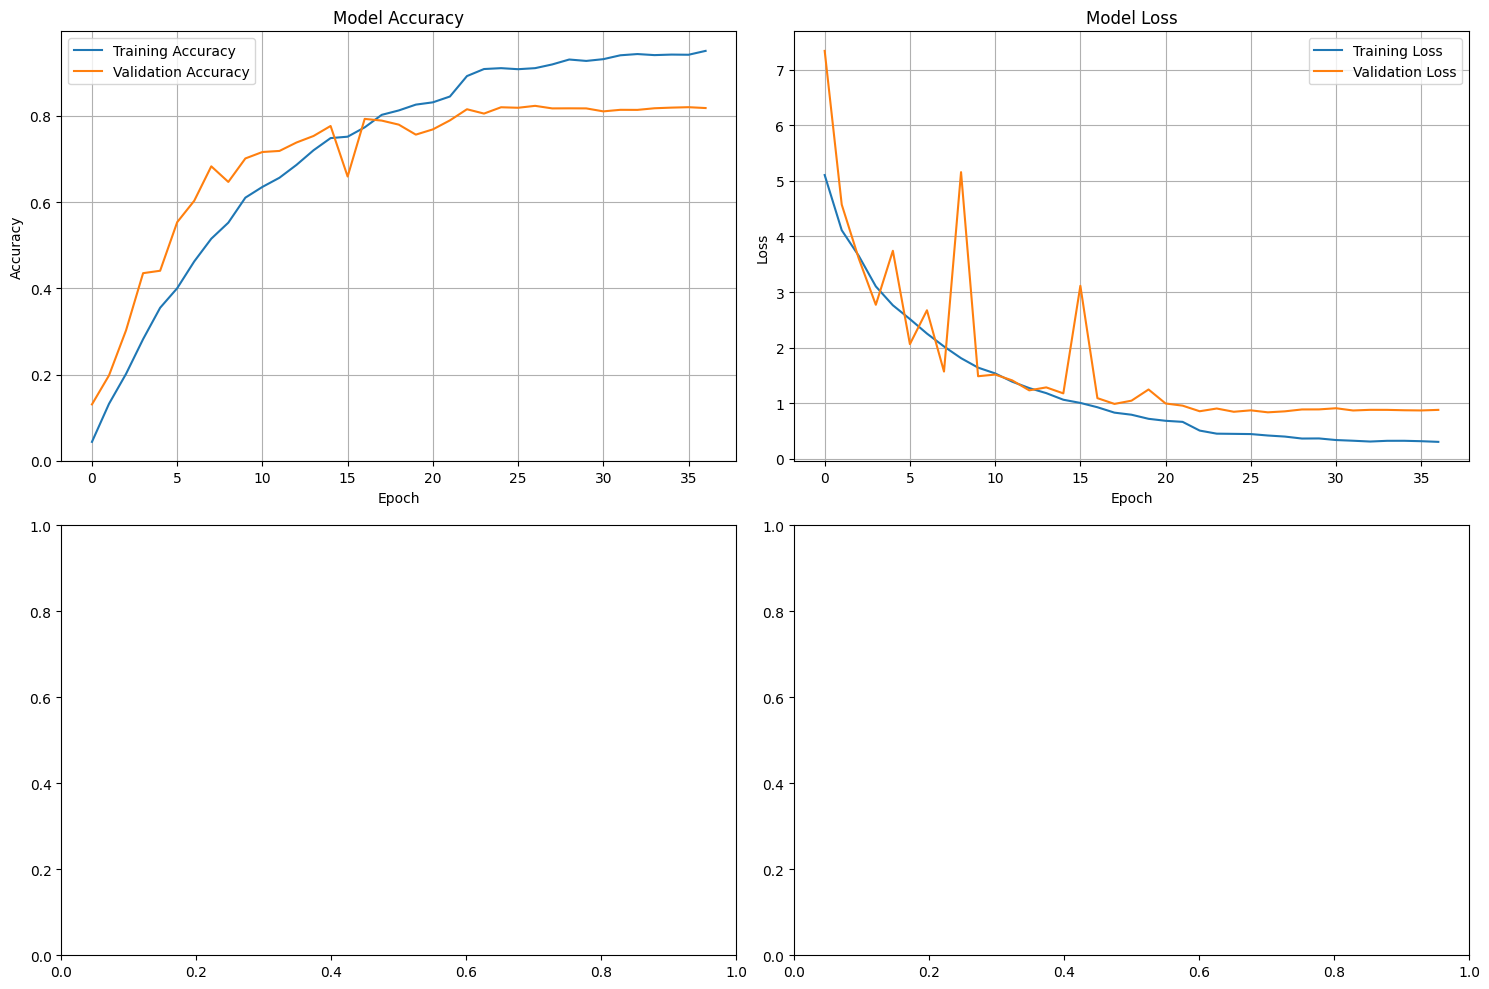

Evaluating model...
Test Results:
- Test Loss: 0.8368
- Test Accuracy: 0.8231

TRAINING COMPLETE!


In [ ]:
def main():
    """Main training pipeline"""

    # Initialize configuration
    config = Caltech101Config()

    # Initialize components
    data_processor = Caltech101DataProcessor(config)
    model_builder = Caltech101ModelBuilder(config)
    trainer = Caltech101Trainer(config)

    # Load and preprocess data
    ds_train, ds_val, ds_test, ds_info = data_processor.load_dataset()

    # Choose model architecture
    model_name = 'vgg16'
    model_family = model_name.split('_')[0]

    # Preprocess datasets
    print("Preprocessing datasets...")
    train_dataset = data_processor.preprocess_data(ds_train, model_family, is_training=True)
    val_dataset = data_processor.preprocess_data(ds_val, model_family, is_training=False)
    test_dataset = data_processor.preprocess_data(ds_test, model_family, is_training=False)

    # Build model
    model, base_model = model_builder.build_model(model_name)
    model = trainer.compile_model(model)

    print("Model Summary:")
    model.summary()


    # Fine-tuning
    print("\n" + "="*50)
    print(" Fine-tuning")
    print("="*50)

    model_builder.setup_fine_tuning(base_model, learning_rate=1e-4)
    model = trainer.compile_model(model, learning_rate=1e-4)

    # Reduce epochs for fine-tuning
    config.epochs = 50
    history2 = trainer.train_model(model, train_dataset, test_dataset, f"{model_name}_phase2")

    # Plot training history
    trainer.plot_training_history(
        save_path=config.results_dir / f"{model_name}_training_history.png"
    )

    # Evaluate model
    results = trainer.evaluate_model(model, test_dataset)

    # Save results
    # results_file = config.results_dir / f"{model_name}_results.json"
    # with open(results_file, 'w') as f:
    #     # Convert numpy arrays to lists for JSON serialization
    #     json_results = {k: v.tolist() if isinstance(v, np.ndarray) else v
    #                    for k, v in results.items() if k != 'classification_report'}
    #     json_results['classification_report'] = results['classification_report']
    #     json.dump(json_results, f, indent=2)

    # print(f"\nTraining completed! Results saved to {config.results_dir}")
    return model, results

if __name__ == "__main__":
    # Run the main pipeline
    model, results = main()

    print("\n" + "="*50)
    print("TRAINING COMPLETE!")
    print("="*50)
